In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t()) 
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features

In [6]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img = get_image('content.png', img_transform)
style_img = get_image('style.png', img_transform)
generated_img = content_img.clone()    
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
    p.requires_grad = False

In [7]:
content_weight = 1
style_weight = 100

for epoch in range(5000):
    
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        bs, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w) 

    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: 0.0000	Style Loss: 3992.7981
Epoch [10]	Content Loss: 0.9681	Style Loss: 3360.9443
Epoch [20]	Content Loss: 2.0120	Style Loss: 2781.5466
Epoch [30]	Content Loss: 2.5801	Style Loss: 2338.8423
Epoch [40]	Content Loss: 2.9470	Style Loss: 1989.7972
Epoch [50]	Content Loss: 3.2089	Style Loss: 1710.8044
Epoch [60]	Content Loss: 3.4074	Style Loss: 1482.2273
Epoch [70]	Content Loss: 3.5700	Style Loss: 1291.2787
Epoch [80]	Content Loss: 3.7118	Style Loss: 1130.3660
Epoch [90]	Content Loss: 3.8308	Style Loss: 994.5214
Epoch [100]	Content Loss: 3.9348	Style Loss: 880.3469
Epoch [110]	Content Loss: 4.0244	Style Loss: 784.8891
Epoch [120]	Content Loss: 4.1005	Style Loss: 705.5377
Epoch [130]	Content Loss: 4.1687	Style Loss: 639.8880
Epoch [140]	Content Loss: 4.2300	Style Loss: 585.5807
Epoch [150]	Content Loss: 4.2848	Style Loss: 540.6045
Epoch [160]	Content Loss: 4.3326	Style Loss: 503.2412
Epoch [170]	Content Loss: 4.3738	Style Loss: 471.9776
Epoch [180]	Content Loss: 4.41

Epoch [1520]	Content Loss: 5.1089	Style Loss: 57.6056
Epoch [1530]	Content Loss: 5.1113	Style Loss: 57.0975
Epoch [1540]	Content Loss: 5.1140	Style Loss: 56.5960
Epoch [1550]	Content Loss: 5.1164	Style Loss: 56.1004
Epoch [1560]	Content Loss: 5.1190	Style Loss: 55.6109
Epoch [1570]	Content Loss: 5.1214	Style Loss: 55.1276
Epoch [1580]	Content Loss: 5.1234	Style Loss: 54.6504
Epoch [1590]	Content Loss: 5.1254	Style Loss: 54.1799
Epoch [1600]	Content Loss: 5.1273	Style Loss: 53.7146
Epoch [1610]	Content Loss: 5.1291	Style Loss: 53.2547
Epoch [1620]	Content Loss: 5.1310	Style Loss: 52.8010
Epoch [1630]	Content Loss: 5.1330	Style Loss: 52.3533
Epoch [1640]	Content Loss: 5.1352	Style Loss: 51.9110
Epoch [1650]	Content Loss: 5.1373	Style Loss: 51.4744
Epoch [1660]	Content Loss: 5.1391	Style Loss: 51.0429
Epoch [1670]	Content Loss: 5.1408	Style Loss: 50.6168
Epoch [1680]	Content Loss: 5.1427	Style Loss: 50.1959
Epoch [1690]	Content Loss: 5.1447	Style Loss: 49.7799
Epoch [1700]	Content Loss: 5

Epoch [3040]	Content Loss: 5.3462	Style Loss: 19.7586
Epoch [3050]	Content Loss: 5.3470	Style Loss: 19.6445
Epoch [3060]	Content Loss: 5.3480	Style Loss: 19.5311
Epoch [3070]	Content Loss: 5.3489	Style Loss: 19.4186
Epoch [3080]	Content Loss: 5.3499	Style Loss: 19.3066
Epoch [3090]	Content Loss: 5.3511	Style Loss: 19.1956
Epoch [3100]	Content Loss: 5.3523	Style Loss: 19.0854
Epoch [3110]	Content Loss: 5.3533	Style Loss: 18.9760
Epoch [3120]	Content Loss: 5.3547	Style Loss: 18.8672
Epoch [3130]	Content Loss: 5.3560	Style Loss: 18.7592
Epoch [3140]	Content Loss: 5.3571	Style Loss: 18.6520
Epoch [3150]	Content Loss: 5.3585	Style Loss: 18.5456
Epoch [3160]	Content Loss: 5.3597	Style Loss: 18.4401
Epoch [3170]	Content Loss: 5.3607	Style Loss: 18.3352
Epoch [3180]	Content Loss: 5.3621	Style Loss: 18.2311
Epoch [3190]	Content Loss: 5.3635	Style Loss: 18.1278
Epoch [3200]	Content Loss: 5.3650	Style Loss: 18.0253
Epoch [3210]	Content Loss: 5.3662	Style Loss: 17.9234
Epoch [3220]	Content Loss: 5

Epoch [4570]	Content Loss: 5.5223	Style Loss: 8.9772
Epoch [4580]	Content Loss: 5.5217	Style Loss: 8.9410
Epoch [4590]	Content Loss: 5.5256	Style Loss: 8.8914
Epoch [4600]	Content Loss: 5.5220	Style Loss: 8.8644
Epoch [4610]	Content Loss: 5.5296	Style Loss: 8.8054
Epoch [4620]	Content Loss: 5.5232	Style Loss: 8.7859
Epoch [4630]	Content Loss: 5.5317	Style Loss: 8.7240
Epoch [4640]	Content Loss: 5.5268	Style Loss: 8.7002
Epoch [4650]	Content Loss: 5.5338	Style Loss: 8.6442
Epoch [4660]	Content Loss: 5.5286	Style Loss: 8.6227
Epoch [4670]	Content Loss: 5.5356	Style Loss: 8.5655
Epoch [4680]	Content Loss: 5.5315	Style Loss: 8.5401
Epoch [4690]	Content Loss: 5.5388	Style Loss: 8.4854
Epoch [4700]	Content Loss: 5.5330	Style Loss: 8.4645
Epoch [4710]	Content Loss: 5.5398	Style Loss: 8.4087
Epoch [4720]	Content Loss: 5.5358	Style Loss: 8.3825
Epoch [4730]	Content Loss: 5.5399	Style Loss: 8.3350
Epoch [4740]	Content Loss: 5.5398	Style Loss: 8.2984
Epoch [4750]	Content Loss: 5.5386	Style Loss: 

(-0.5, 299.5, 299.5, -0.5)

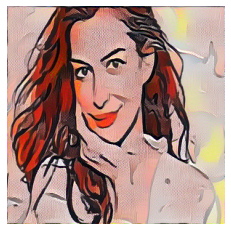

In [8]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)
plt.axis("off")